# RFM Analysis

This iPython notebook explains how to perform RFM analysis from customer purchase history data. The sample orders file is Sample - Superstore dataset from Tableau Software.

If you have suggestions or improvements please contribute on https://github.com/joaolcorreia/RFM-analysis

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_bq(query_):
    from google.cloud import bigquery

    client = bigquery.Client()
    query_job = client.query(query_)
    return query_job.result().to_dataframe()

In [5]:
query = 'SELECT * FROM `htz-common.aggregated_data.RFV_Only`'
data = read_bq(query)
data.set_index('sso_id',inplace=True)

In [7]:
rfmTable = data

## Validating the RFM Table

In [8]:
rfmTable.head()

,R,F,V
sso_id,,,
50000088052,10,169,208
50000107121,8,16,24
9037438908,8,75,91
8983528165,7,73,120
7811123207,11,39,46


Customer **Aaron Bergman** has frequency:3, monetary value:$887 and recency:415 days.

## Determining RFM Quartiles

In [9]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])

In [20]:
quantiles

{'R': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'F': {0.25: 118.0, 0.5: 282.0, 0.75: 529.0},
 'V': {0.25: 178.0, 0.5: 483.0, 0.75: 1005.5}}

Send quantiles to a dictionary, easier to use.

In [11]:
quantiles = quantiles.to_dict()

In [12]:
quantiles

{'R': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'F': {0.25: 118.0, 0.5: 282.0, 0.75: 529.0},
 'V': {0.25: 178.0, 0.5: 483.0, 0.75: 1005.5}}

## Creating the RFM segmentation table

In [13]:
rfmSegmentation = rfmTable

In [21]:
rfmSegmentation

,R,F,V,R_Quartile,F_Quartile
sso_id,,,,,
50000088052,10,169,208,4,3
50000107121,8,16,24,4,4
9037438908,8,75,91,4,4
8983528165,7,73,120,4,4
7811123207,11,39,46,4,4
...,...,...,...,...,...
8011842880,6,16,15,4,4
50000072681,6,26,28,4,4
50000146707,6,21,17,4,4


We create two classes for the RFM segmentation since, being high recency is bad, while high frequency and monetary value is good. 

In [14]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1


In [22]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['R'].apply(RClass, args=('R',quantiles,))
rfmSegmentation['F_Quartile'] = rfmSegmentation['F'].apply(FMClass, args=('F',quantiles,))
rfmSegmentation['M_Quartile'] = rfmSegmentation['V'].apply(FMClass, args=('V',quantiles,))

In [23]:
rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) \
                            + rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str)

In [24]:
rfmSegmentation.head()

,R,F,V,R_Quartile,F_Quartile,M_Quartile,RFMClass
sso_id,,,,,,,
50000088052,10,169,208,4,3,3,433
50000107121,8,16,24,4,4,4,444
9037438908,8,75,91,4,4,4,444
8983528165,7,73,120,4,4,4,444
7811123207,11,39,46,4,4,4,444


In [31]:
rfmSegmentation['RFMClass'].value_counts()

111    7883
133    6382
122    6051
444    4559
144    4318
112    2022
121    1960
123    1883
132    1810
134     993
143     902
433     478
443     262
131     184
434     134
113     120
432      65
422      54
124      50
423      36
142      27
141      11
442      10
421       9
412       6
431       6
411       2
114       2
Name: RFMClass, dtype: int64

Who are the top 5 users customers? by RFM Class (111), 

In [71]:
rfmSegmentation[rfmSegmentation['RFMClass']=='111'].sort_values('V', ascending=False).head(10)

,R,F,V,R_Quartile,F_Quartile,M_Quartile,RFMClass
sso_id,,,,,,,
3010,1,26681,32191,1,1,1,111
1006,1,18965,23508,1,1,1,111
7594535417,1,2072,15610,1,1,1,111
8945759089,1,627,11527,1,1,1,111
7596246812,1,1085,10150,1,1,1,111
77040,1,4946,8752,1,1,1,111
7592491532,1,634,8557,1,1,1,111
9015494183,1,1073,8464,1,1,1,111
7690779062,1,884,8182,1,1,1,111


In [102]:
merged[merged.RFMClass.isin(['444'])]

,mobile,desktop,app,amp,fb_instant,other,null_source,push_notification,app_share,smartfocus,...,culture,food,opinions,literature,captain,sport,other_secs,devices,RFMClass,class
sso_id,,,,,,,,,,,,,,,,,,,,,
9037732873,0,0,4,0,0,0,4,0,0,0,...,0,0,0,2,0,0,1,1,444,27
50000222323,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,444,27
50000149241,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,444,27
9017599080,0,0,1,0,0,0,0,1,0,0,...,0,0,2,0,0,0,0,1,444,27
50000142236,4,0,0,0,0,0,4,0,2,0,...,0,0,0,1,0,0,6,1,444,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3367498457,20,103,0,37,0,0,74,0,7,0,...,22,16,6,1,3,13,37,31,444,27
7609260487,18,86,141,3,0,0,147,3,0,7,...,109,8,18,7,9,4,116,31,444,27
8868710004,7,38,57,0,0,0,74,1,2,0,...,10,3,8,2,4,2,81,32,444,27


In [34]:
query = 'select * from `htz-common.aggregated_data.rfv`'
data = read_bq(query)
data.set_index('sso_id',inplace=True)

In [38]:
merged = data.join(rfmSegmentation['RFMClass'], on='sso_id')
merged.dropna(inplace=True)

In [52]:
merged

,mobile,desktop,app,amp,fb_instant,other,null_source,push_notification,app_share,smartfocus,...,weekend,culture,food,opinions,literature,captain,sport,other_secs,devices,RFMClass
sso_id,,,,,,,,,,,,,,,,,,,,,
9037732873,0,0,4,0,0,0,4,0,0,0,...,0,0,0,0,2,0,0,1,1,444
50000222323,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,444
50000149241,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,444
9017599080,0,0,1,0,0,0,0,1,0,0,...,0,0,0,2,0,0,0,0,1,444
50000142236,4,0,0,0,0,0,4,0,2,0,...,2,0,0,0,1,0,0,6,1,444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7871397952,6,236,269,0,0,0,865,4,2,0,...,19,302,23,55,4,36,9,98,121,113
7654656613,177,491,335,0,66,0,1076,3,2,1,...,138,363,22,102,49,27,14,239,123,112
8011840063,1641,834,0,43,0,0,1587,0,1,1,...,113,330,154,54,28,96,94,399,157,111


In [55]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(merged.iloc[:,-1])
le.transform(merged.iloc[:,-1])
merged['class'] = le.transform(merged.iloc[:,-1])
merged['class']

sso_id
9037732873     27
50000222323    27
50000149241    27
9017599080     27
50000142236    27
               ..
7871397952      2
7654656613      1
8011840063      0
7593717843      0
3010            0
Name: class, Length: 39460, dtype: int32

In [75]:
merged.iloc[:,-1].unique().size

28

In [88]:
def plot_corr(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

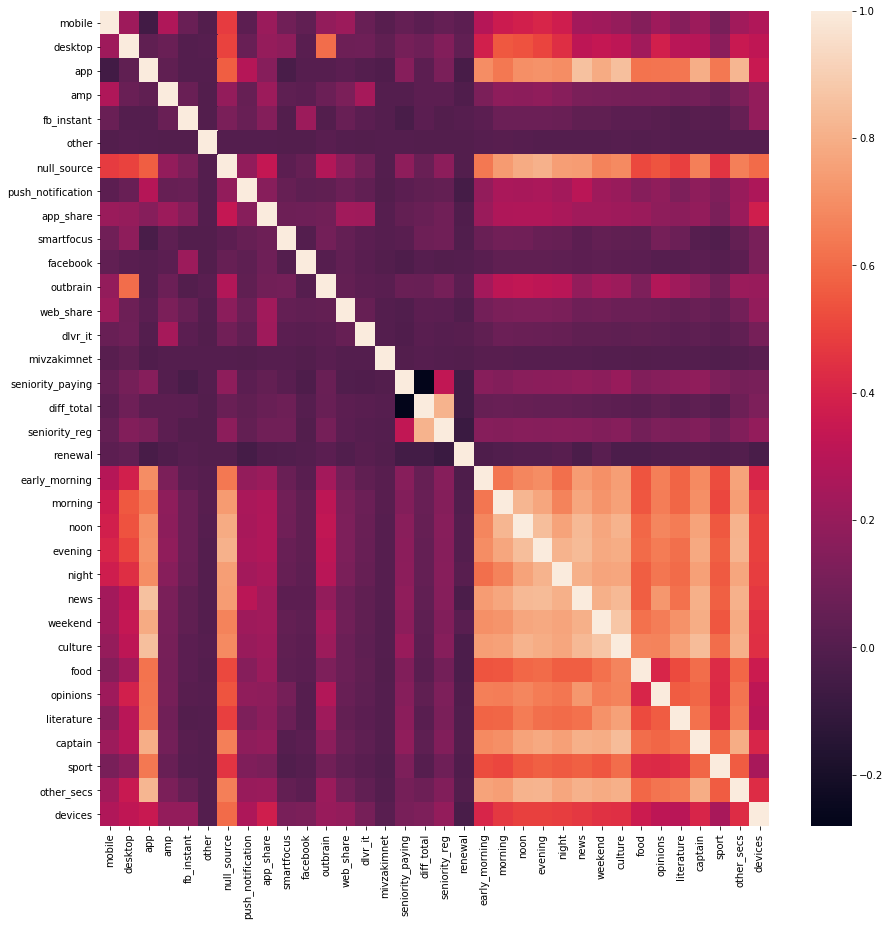

In [92]:
corr = data.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr)

In [98]:
platform_columns = ['mobile', 'desktop', 'app', 'amp', 'fb_instant', 'other']
source_columns = ['null_source',
       'push_notification', 'app_share', 'smartfocus', 'facebook', 'outbrain',
       'web_share', 'dlvr_it', 'mivzakimnet']
secs_columns = ['news', 'weekend', 'culture', 'food', 'opinions',
       'literature', 'captain', 'sport', 'other_secs']


In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import numpy as np
y = merged.iloc[:,-1]
X = merged.loc[:,platform_columns+source_columns+secs_columns]

sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X, y)
selected_columns =  X.columns[(sel.get_support())]

In [100]:
selected_columns

Index(['desktop', 'app', 'null_source', 'news', 'weekend', 'culture',
       'opinions', 'other_secs'],
      dtype='object')